In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')


In [2]:
def load_emotional_speech_dataset():
    paths = []
    labels = []

    dataset_dir = r'E:\coders\speech emotion\emotional-speech\TESS Toronto emotional speech set data\TESS Toronto emotional speech set data'

    for root, _, filenames in os.walk(dataset_dir):
        for filename in filenames:
            paths.append(os.path.join(root, filename))
            label = filename.split('_')[-1].split('.')[0]
            labels.append(label.lower())

    print('Speech Emotion Dataset was Loaded')

    return paths, labels

In [3]:
# Call the function to load the dataset
dataset_paths, dataset_labels = load_emotional_speech_dataset()

# Create a DataFrame
data_frame = pd.DataFrame()
data_frame['speech'] = dataset_paths
data_frame['label'] = dataset_labels

# Count the occurrences of each label
label_counts = data_frame['label'].value_counts()

Speech Emotion Dataset was Loaded


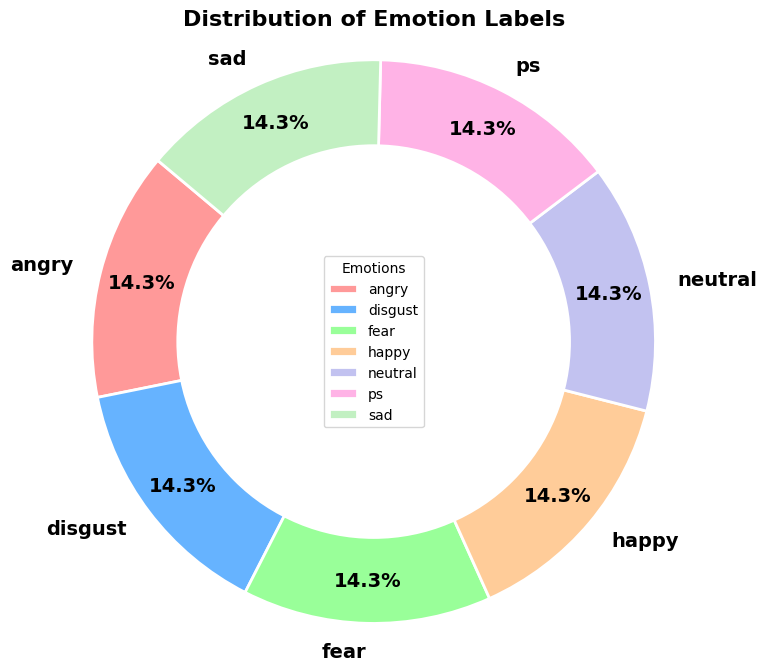

In [4]:
import matplotlib.pyplot as plt

# Define colors for the pie chart
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c2f0c2']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Create a pie chart
wedges, texts, autotexts = ax.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors,
    textprops={'fontsize': 14, 'weight': 'bold'},  # Customize text properties
    wedgeprops={'linewidth': 2, 'edgecolor': 'w'},  # Add a white border to the wedges
    pctdistance=0.85  # Adjust the distance of autopct from the center
)

# Custom legend in the center of the graph
ax.legend(wedges, label_counts.index, title="Emotions", loc="center", bbox_to_anchor=(0.5, 0.5))

ax.set_title("Distribution of Emotion Labels", fontsize=16, fontweight='bold')

# Add a circle at the center to make it look like a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax.add_artist(centre_circle)

# Equal aspect ratio ensures that the pie is drawn as a circle
ax.axis('equal')

plt.show()


In [5]:
def plot_waveform(data, sr, emotion):
    plt.figure(figsize=(12, 6))  # Adjust figure size
    plt.title(f'Waveform for {emotion} Emotion', fontsize=20, fontweight='bold')
    
    librosa.display.waveshow(data, sr=sr, color='b')
    
    # Add labels to the axes
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    
    # Add grid lines for better visualization
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add a legend
    legend_text = f'Sample Rate: {sr} Hz'
    plt.legend([legend_text], loc='upper right', fontsize=12)
    
    plt.show()


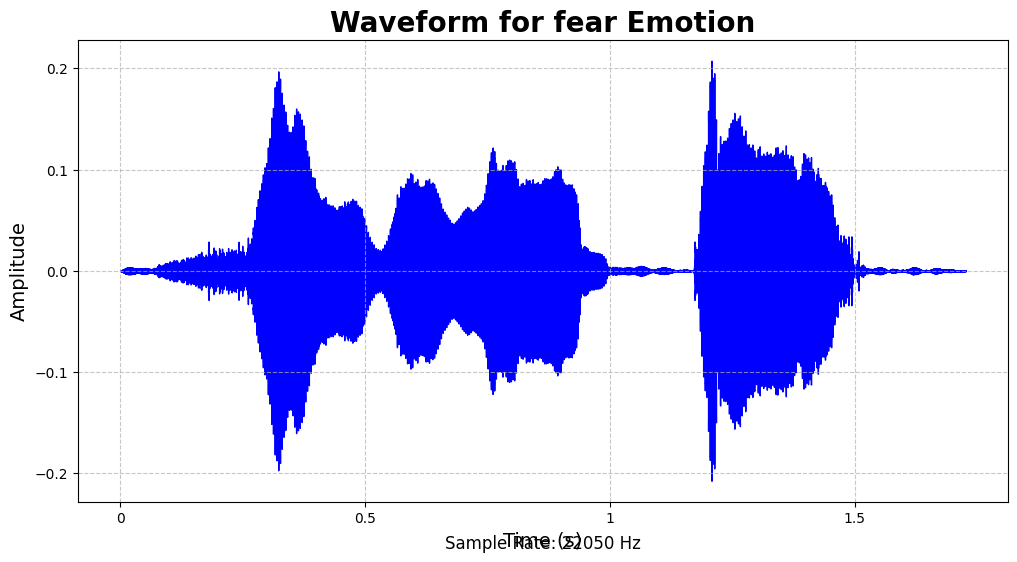

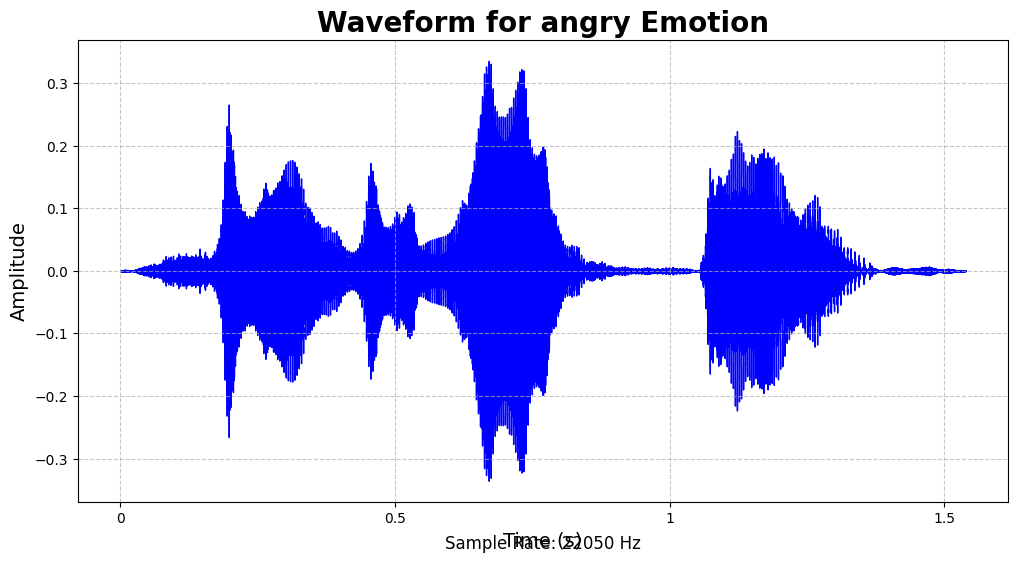

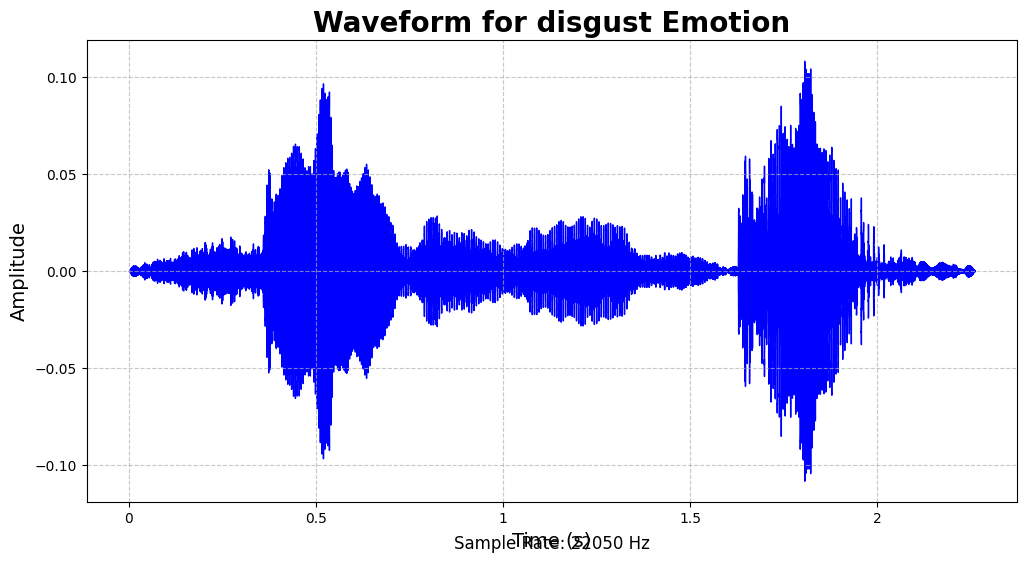

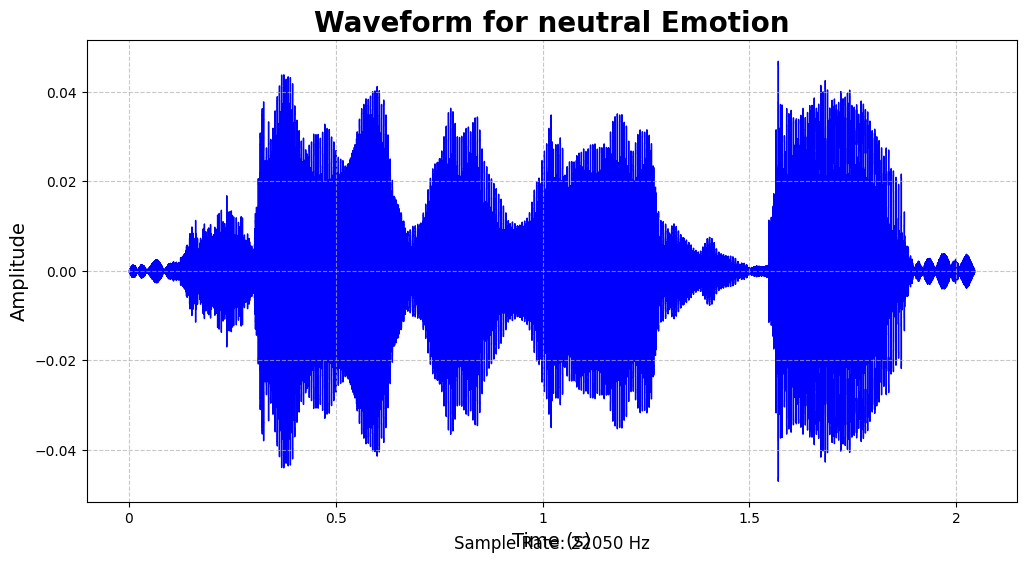

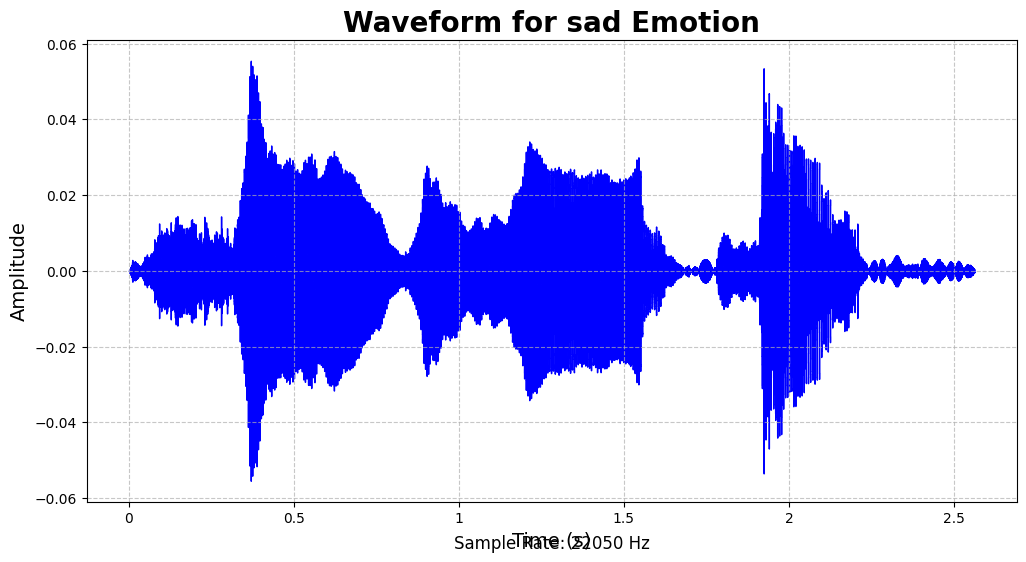

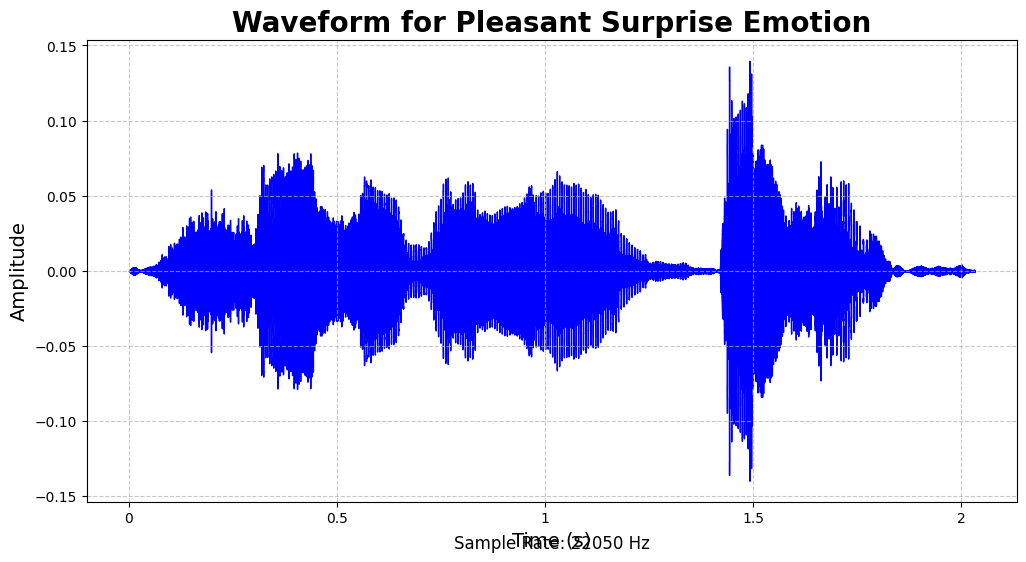

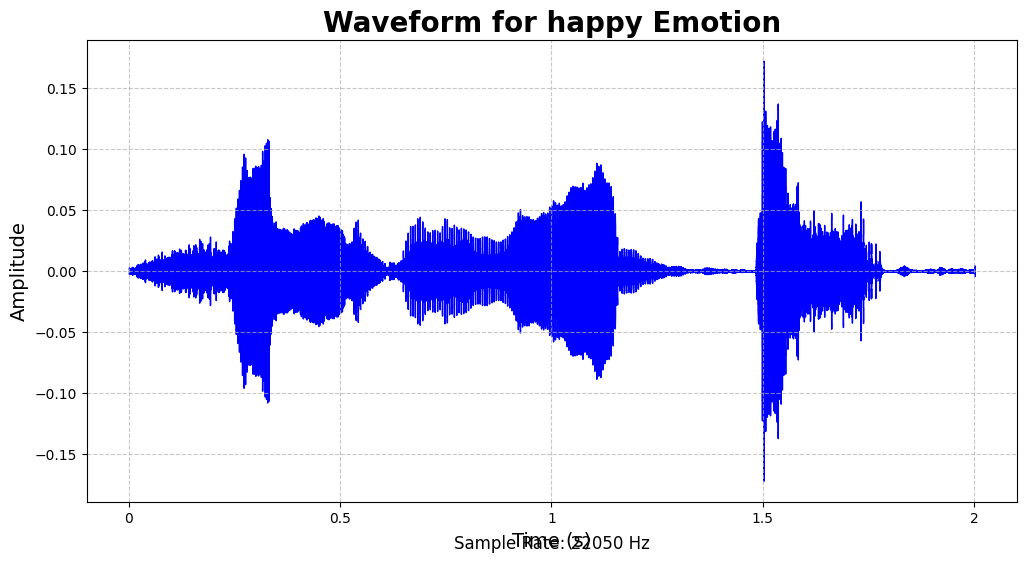

In [6]:
from IPython.display import display, HTML, Audio

emotions_to_plot = ['fear', 'angry', 'disgust', 'neutral', 'sad', 'ps', 'happy']

def plot_waveform_with_audio(data, sr, emotion, audio_path):
    plt.figure(figsize=(12, 6))
    plt.title(f'Waveform for {emotion} Emotion', fontsize=20, fontweight='bold')
    librosa.display.waveshow(data, sr=sr, color='b')
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add sample rate information as text on the plot
    plt.text(0.5, -0.1, f'Sample Rate: {sr} Hz', fontsize=12, ha='center', transform=plt.gca().transAxes)

    # Create play and pause buttons for audio
    audio_html = Audio(data=audio_path, autoplay=False, element_id=f'{emotion}_audio')
    display(HTML(f'<br><button onclick="document.getElementById(\'{emotion}_audio\').play()">Play {emotion} Audio</button>'))
    display(HTML(f'<button onclick="document.getElementById(\'{emotion}_audio\').pause()">Pause {emotion} Audio</button>'))

    plt.show()

# Use the function to display waveform plots with audio controls
for emotion in emotions_to_plot:
    if emotion in data_frame['label'].values:
        path = data_frame[data_frame['label'] == emotion]['speech'].iloc[0]
        data, sampling_rate = librosa.load(path)
        if emotion == 'ps':
            emotion = 'Pleasant Surprise'
        plot_waveform_with_audio(data, sr=sampling_rate, emotion=emotion, audio_path=path)
    else:
        print(f"No data found for emotion: {emotion}")


In [7]:
def extract_Mel_freq_cc(filename):
    y, sr = librosa.load(filename, duration = 3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr = sr, n_mfcc = 40).T, axis = 0)
    return mfcc
     

x_Mel_freq_cc = data_frame['speech'].apply(lambda x: extract_Mel_freq_cc(x))

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Assuming x_Mel_freq_cc is a list containing your data
x = [x for x in x_Mel_freq_cc]

# Convert x to a NumPy array
x = np.array(x)

# Check the shape of x
print("Shape of x before expanding dimensions:", x.shape)

# Expand the dimensions of x
x = np.expand_dims(x, -1)

# Check the shape of x after expanding dimensions
print("Shape of x after expanding dimensions:", x.shape)

# Assuming data_frame is your DataFrame containing the 'label' column
enc = OneHotEncoder(sparse=False)

# Fit and transform the 'label' column to one-hot encoded format
y = enc.fit_transform(data_frame[['label']])

# Check the shape of y
print("Shape of y before enhancing:", y.shape)

# You can enhance it by adding the number of unique labels as the second dimension
# This will make it compatible for further processing
num_unique_labels = y.shape[1]

# Create an array of zeros with the enhanced shape
enhanced_y = np.zeros((y.shape[0], num_unique_labels))

# Copy the one-hot encoded values to the enhanced array
enhanced_y[:, :y.shape[1]] = y

# Check the shape of the enhanced y
print("Shape of enhanced y:", enhanced_y.shape)

Shape of x before expanding dimensions: (2800, 40)
Shape of x after expanding dimensions: (2800, 40, 1)
Shape of y before enhancing: (2800, 7)
Shape of enhanced y: (2800, 7)


In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, LearningRateScheduler

def create_model(input_shape, num_classes, learning_rate):
    model = Sequential()
    
    # LSTM layers
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=False))
    
    # Fully connected layers
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

input_shape = (40, 1)  # Adjust the input shape based on your data
num_classes = 7  # Number of output classes
learning_rate = 0.001  # Adjust the learning rate as needed

model = create_model(input_shape, num_classes, learning_rate)

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 256)           264192    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Train the model with data splitting and additional callbacks
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=256,
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/100


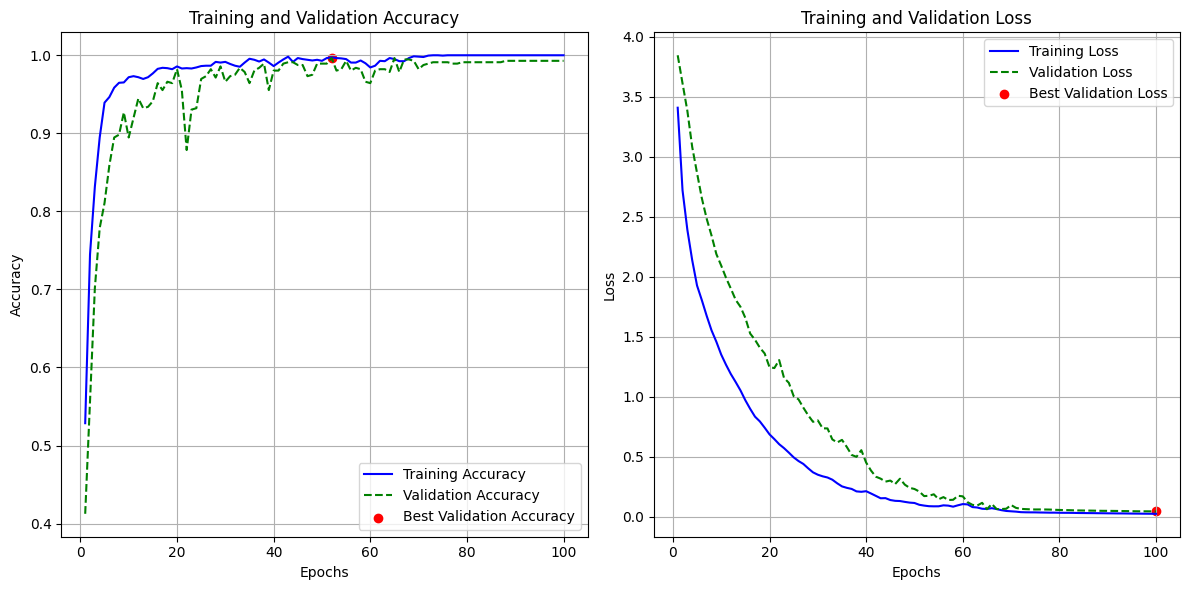

In [ ]:
import matplotlib.pyplot as plt

# Visualize training and validation accuracy and loss
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'g--', label='Validation Accuracy')
best_val_acc_epoch = epochs[np.argmax(history.history['val_accuracy'])]
best_val_acc = max(history.history['val_accuracy'])
plt.scatter(best_val_acc_epoch, best_val_acc, color='red', marker='o', label='Best Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'g--', label='Validation Loss')
best_val_loss_epoch = epochs[np.argmin(history.history['val_loss'])]
best_val_loss = min(history.history['val_loss'])
plt.scatter(best_val_loss_epoch, best_val_loss, color='red', marker='o', label='Best Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
